# Train a VAE on Cell Painting LINCS Data

In [10]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap


In [13]:
def remove_moa(df):
    pipes = ['NFkB pathway inhibitor|proteasome inhibitor'
         'microtubule inhibitor|tubulin polymerization inhibitor',
             'Aurora kinase inhibitor|JAK inhibitor',
             'DNA inhibitor|topoisomerase inhibitor',
            'RNA synthesis inhibitor|topoisomerase inhibitor']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [14]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [15]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [16]:
print(train_features_df.shape)
train_features_df.head(3)

(8068, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [17]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [18]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [19]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [20]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
cp_vae.compile_vae()

In [21]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
85/85 [==============================] - 4s 16ms/step - loss: 67.8469 - recon: 30.1848 - kl: 2.4606 - mmd: 0.0000e+00 - val_loss: 23.4275 - val_recon: 18.2653 - val_kl: 5.1622 - val_mmd: 0.0000e+00
Epoch 2/100
85/85 [==============================] - 0s 6ms/step - loss: 9.8177 - recon: 7.4430 - kl: 1.5329 - mmd: 0.0000e+00 - val_loss: 10.3434 - val_recon: 7.5864 - val_kl: 2.7570 - val_mmd: 0.0000e+00
Epoch 3/100
85/85 [==============================] - 0s 6ms/step - loss: 7.1592 - recon: 5.6275 - kl: 1.1449 - mmd: 0.0000e+00 - val_loss: 7.1005 - val_recon: 5.6042 - val_kl: 1.4963 - val_mmd: 0.0000e+00
Epoch 4/100
85/85 [==============================] - 0s 6ms/step - loss: 5.9198 - recon: 4.7173 - kl: 0.9715 - mmd: 0.0000e+00 - val_loss: 5.4344 - val_recon: 4.4540 - val_kl: 0.9805 - val_mmd: 0.0000e+00
Epoch 5/100
85/85 [==============================] - 0s 6ms/step - loss: 5.0279 - recon: 4.1449 - kl: 0.8725 - mmd: 0.0000e+00 - val_loss: 4.8155 - val_recon: 3.8539 - val_kl

Epoch 41/100
85/85 [==============================] - 0s 6ms/step - loss: 3.8342 - recon: 3.1041 - kl: 0.8123 - mmd: 0.0000e+00 - val_loss: 3.8391 - val_recon: 2.9050 - val_kl: 0.9342 - val_mmd: 0.0000e+00
Epoch 42/100
85/85 [==============================] - 0s 6ms/step - loss: 3.8083 - recon: 3.1096 - kl: 0.8156 - mmd: 0.0000e+00 - val_loss: 3.9600 - val_recon: 3.0238 - val_kl: 0.9362 - val_mmd: 0.0000e+00
Epoch 43/100
85/85 [==============================] - 0s 6ms/step - loss: 3.9144 - recon: 3.1035 - kl: 0.8138 - mmd: 0.0000e+00 - val_loss: 3.9515 - val_recon: 2.9649 - val_kl: 0.9866 - val_mmd: 0.0000e+00
Epoch 44/100
85/85 [==============================] - 0s 6ms/step - loss: 3.9058 - recon: 3.0514 - kl: 0.8178 - mmd: 0.0000e+00 - val_loss: 3.8495 - val_recon: 2.8695 - val_kl: 0.9801 - val_mmd: 0.0000e+00
Epoch 45/100
85/85 [==============================] - 0s 6ms/step - loss: 3.8654 - recon: 3.0904 - kl: 0.8336 - mmd: 0.0000e+00 - val_loss: 3.8784 - val_recon: 3.0115 - val_kl:

Epoch 81/100
85/85 [==============================] - 0s 6ms/step - loss: 3.7747 - recon: 2.7074 - kl: 1.0137 - mmd: 0.0000e+00 - val_loss: 3.5938 - val_recon: 2.5986 - val_kl: 0.9952 - val_mmd: 0.0000e+00
Epoch 82/100
85/85 [==============================] - 0s 6ms/step - loss: 3.7056 - recon: 2.6846 - kl: 1.0258 - mmd: 0.0000e+00 - val_loss: 3.6327 - val_recon: 2.6076 - val_kl: 1.0251 - val_mmd: 0.0000e+00
Epoch 83/100
85/85 [==============================] - 0s 5ms/step - loss: 3.6299 - recon: 2.6774 - kl: 1.0075 - mmd: 0.0000e+00 - val_loss: 3.7526 - val_recon: 2.5413 - val_kl: 1.2113 - val_mmd: 0.0000e+00
Epoch 84/100
85/85 [==============================] - 0s 6ms/step - loss: 3.7111 - recon: 2.6862 - kl: 1.0247 - mmd: 0.0000e+00 - val_loss: 3.4576 - val_recon: 2.4358 - val_kl: 1.0218 - val_mmd: 0.0000e+00
Epoch 85/100
85/85 [==============================] - 0s 6ms/step - loss: 3.5716 - recon: 2.6339 - kl: 1.0179 - mmd: 0.0000e+00 - val_loss: 3.7730 - val_recon: 2.7703 - val_kl:

In [22]:
cp_vae.vae

In [23]:
cp_vae.vae.evaluate(test_features_df)

In [24]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,32.645458,30.184826,2.460637,0.0,23.427475,18.265291,5.162182,0.0
1,8.975870,7.442989,1.532880,0.0,10.343382,7.586386,2.756997,0.0
2,6.772408,5.627512,1.144898,0.0,7.100531,5.604202,1.496329,0.0
3,5.688787,4.717299,0.971489,0.0,5.434450,4.453977,0.980472,0.0
4,5.017390,4.144902,0.872489,0.0,4.815503,3.853909,0.961594,0.0
...,...,...,...,...,...,...,...,...
95,3.597152,2.564370,1.032784,0.0,3.566089,2.454175,1.111914,0.0
96,3.620188,2.591627,1.028561,0.0,3.407601,2.244514,1.163087,0.0
97,3.568008,2.541473,1.026535,0.0,3.526345,2.441157,1.085188,0.0
98,3.603958,2.567336,1.036622,0.0,3.369343,2.364366,1.004977,0.0


In [25]:
history_df.to_csv('training_data/level5_training_vanilla_leaveOut.csv')

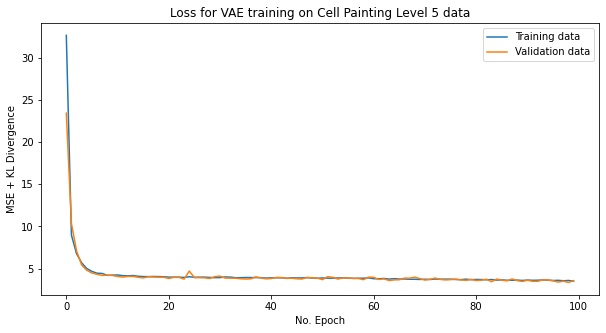

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [28]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

51.87816139528551

<AxesSubplot:>

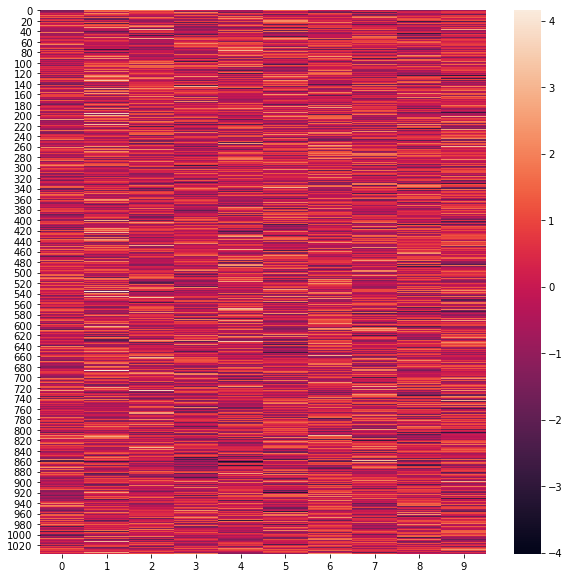

In [29]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [30]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

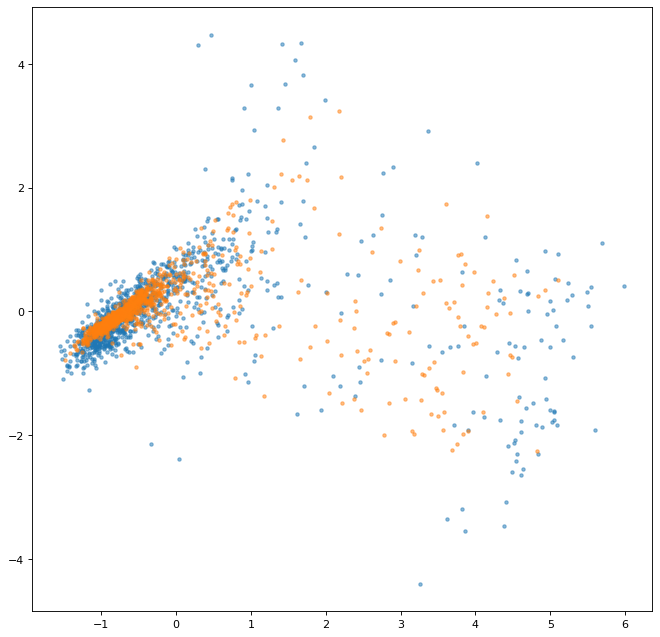

In [31]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [32]:
pca = PCA(n_components=50).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

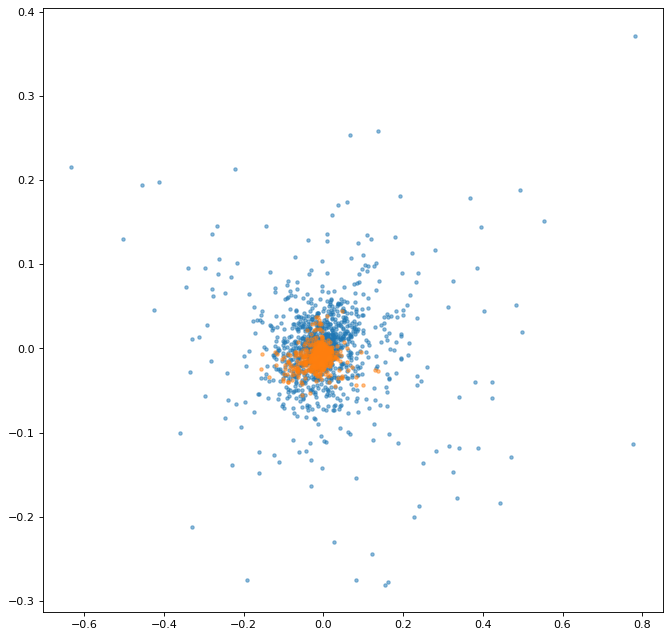

In [33]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[21],pca_test_latent_df[43], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[21],pca_reconstructed_latent_df[43], marker = ".", alpha = 0.5)

<AxesSubplot:>

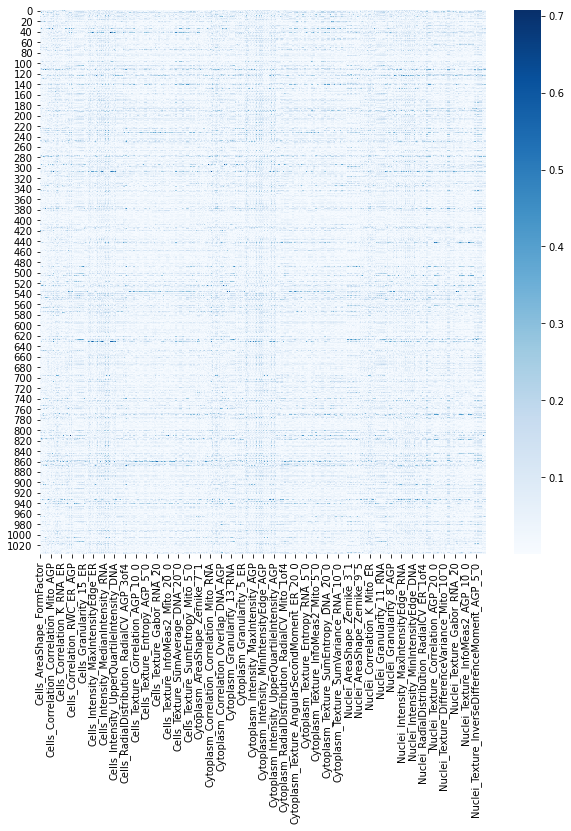

In [38]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

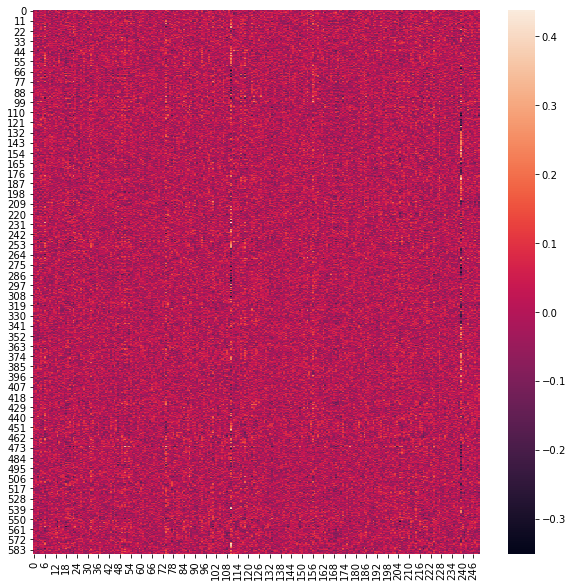

In [39]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [40]:
decoder = cp_vae.decoder_block["decoder"]

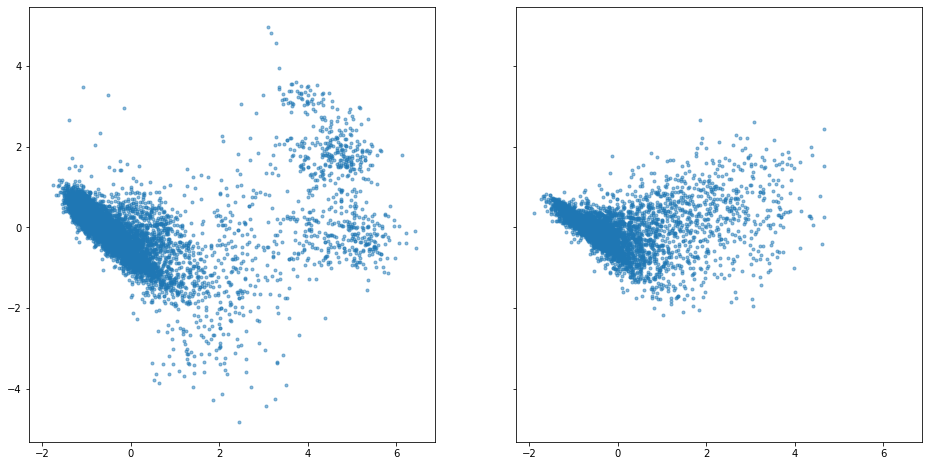

In [41]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [42]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

5.983234581583576

In [12]:
# decoder = keras.models.load_model("level5Decoder")

In [47]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent_vanilla_leaveOut.csv")

In [48]:
reducer = umap.UMAP()
latent_embedding = reducer.fit_transform(latent_df)

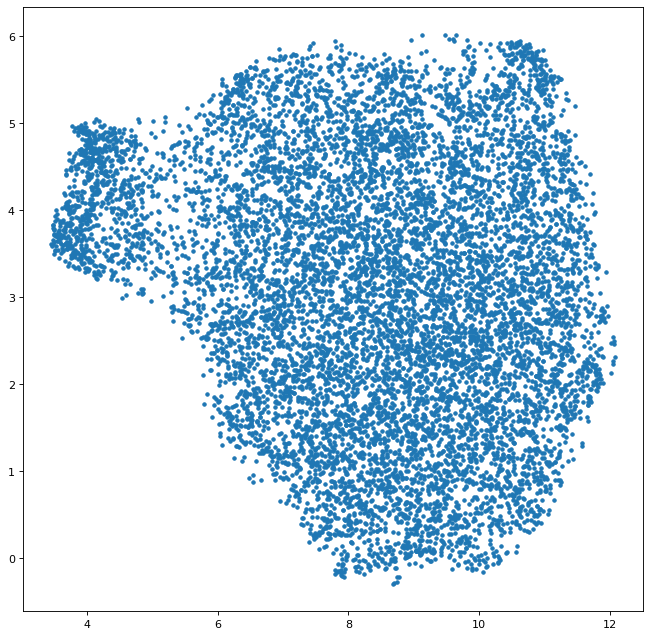

In [49]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    latent_embedding[:, 0],
    latent_embedding[:, 1],
    marker = '.'
)

In [50]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level5Decoder_vanilla_leaveOut")

INFO:tensorflow:Assets written to: level5Decoder_vanilla_leaveOut/assets


In [51]:
encoder.save("models/level5Encoder_vanilla_leaveOut")

INFO:tensorflow:Assets written to: level5Encoder_vanilla_leaveOut/assets
